In [1]:
import numpy as np
import scipy
from scipy.integrate import quad

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy
import astropy.units as u
from astropy.constants import G, k_B, h, c
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import gala
import gala.dynamics as gd
import gala.potential as gp
from gala.potential import NullPotential
import gala.coordinates as gc
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody

from Synth_pop import synthpop


A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


/Users/Tavangar/anaconda3/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/Tavangar/spisea_dependencies/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))



In [2]:
def selfconsistent_plummer(N, M, b):
    """This function generates a stellar system that is consistent 
    with a Plummer, following (more or less) 
    the steps in Aarseth, Henon, Wielen (1974)

    Try to code this up yourself - if you have time."""
    
    np.random.seed(2023)
    
    x1 = np.random.uniform(0, 1, size=N*2)

    r = b * (x1**(-2/3) -1)**-0.5
    r = r[r<5*u.kpc][0:N]

    xyz = np.random.normal(size=(3,N))
    pos = xyz * r.value / np.linalg.norm(xyz, axis=0) * r.unit

    def v_esc(r):
        r = r if isinstance(r, u.Quantity) else r*u.kpc
        pot_abs = G*M / np.sqrt(r**2+b**2)
        return np.sqrt(2 * pot_abs).to('km/s')

    q = np.sqrt(np.random.beta(1.5,4.5, size=N))
    v = q * v_esc(r)

    v_xyz = np.random.normal(size=(3,N))
    vel = v_xyz * v.value / np.linalg.norm(v_xyz, axis=0)*v.unit

    return pos, vel

In [30]:
mw_w0 = gd.PhaseSpacePosition(
    np.zeros(3)*u.kpc,
    np.zeros(3)*u.km/u.s)

lmc_w0 = gd.PhaseSpacePosition(
    [0, 250, 0.] * u.kpc,
    [0, 0, -50]*u.km/u.s)


mw_pot = gp.MilkyWayPotential()
lmc_pot = gp.NFWPotential.from_circular_velocity(
    v_c=90 * u.km / u.s, r_s=4 * u.kpc, r_ref=5 * u.kpc, units=galactic
)

w0 = gd.combine((mw_w0, lmc_w0))

In [40]:
nbody = gd.DirectNBody(w0, particle_potentials=[mw_pot, lmc_pot])
init_orbit = nbody.integrate_orbit(dt=-1*u.Myr, n_steps=int(8000/1))
init_orbit.pos[:,1]

<CartesianRepresentation (x, y, z) in kpc
    [(0.,  250.        , 0.00000000e+00),
     (0.,  249.99996054, 5.11356038e-02),
     (0.,  249.99984216, 1.02271181e-01), ...,
     (0., -202.16520518, 1.23100872e+02),
     (0., -202.22946147, 1.23078699e+02),
     (0., -202.29362719, 1.23056510e+02)]>

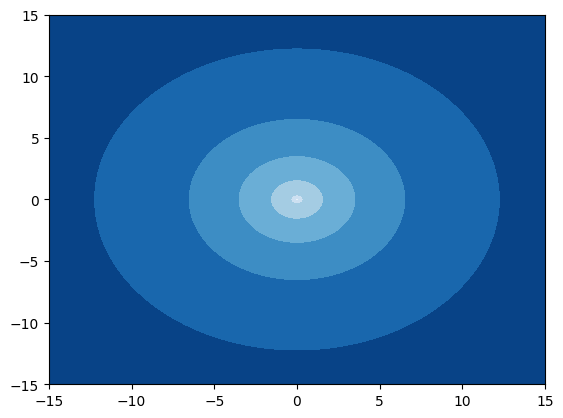

In [27]:
grid = np.linspace(-15,15,1000) * u.kpc
combined_pot.plot_contours(grid=(grid,grid,0))

In [42]:
list([mw_pot, lmc_pot])

[<CompositePotential disk,bulge,nucleus,halo>,
 <NFWPotential: m=3.69e+10, r_s=4.00, a=1.00, b=1.00, c=1.00 (kpc,Myr,solMass,rad)>]

In [108]:
def gc_sim(pos, vel, M_gc, b_gc, dt, N):
    
    # Create a MW potential that includes the lmc
    mw_w0 = gd.PhaseSpacePosition(
        np.zeros(3)*u.kpc,
        np.zeros(3)*u.km/u.s)

    lmc_w0 = gd.PhaseSpacePosition(
        [0, 250, 0.] * u.kpc,
        [0, 0, -50]*u.km/u.s)


    mw_pot = gp.MilkyWayPotential()
    lmc_pot = gp.NFWPotential.from_circular_velocity(
        v_c=90 * u.km / u.s, r_s=4 * u.kpc, r_ref=5 * u.kpc, units=galactic
    )

    # make the Plummer Potential that describes the GC
    M_gc, b_gc = M_gc*u.Msun, b_gc*u.pc
    print(b_gc)
    gc_pot = gp.PlummerPotential(m=M_gc, b=b_gc, 
                                 units=galactic)
    gc_w0 = gd.PhaseSpacePosition(pos=pos,
                                 vel=vel)
    
    w0 = gd.combine((mw_w0, lmc_w0, gc_w0))
    
    print('    Getting Initial Positions...')
    nbody0 = gd.DirectNBody(w0, particle_potentials=[mw_pot, lmc_pot, gc_pot])
    init_orbit = nbody0.integrate_orbit(dt=-dt*u.Myr, n_steps=int(8000/dt))
    init_pos_mw = init_orbit.pos[-1][0] ; init_vel_mw = init_orbit.vel[-1][0]
    init_pos_lmc = init_orbit.pos[-1][1] ; init_vel_lmc = init_orbit.vel[-1][1]
    init_pos_gc = init_orbit.pos[-1][2] ; init_vel_gc = init_orbit.vel[-1][2]
    
    init_mw_w = gd.PhaseSpacePosition(pos=init_pos_mw.xyz,
                                      vel=init_vel_mw.d_xyz)
    init_lmc_w = gd.PhaseSpacePosition(pos=init_pos_lmc.xyz,
                                        vel=init_vel_lmc.d_xyz)
    init_gc_w = gd.PhaseSpacePosition(pos=init_pos_gc.xyz,
                                      vel=init_vel_gc.d_xyz)
    
    #create a ball of test particles in a Plummer Potential
    N = int(N)
    gc_test_pos, gc_test_vel = selfconsistent_plummer(N=N, M=M_gc, b=b_gc)

    gc_test_w = gd.PhaseSpacePosition(pos=gc_test_pos + init_pos_gc.xyz[:,np.newaxis],
                                      vel=gc_test_vel + init_vel_gc.d_xyz[:,np.newaxis])
    
    # combine phase space positions and potentials
    w0 = gd.combine((init_mw_w, init_lmc_w, init_gc_w, gc_test_w))
    particle_pot = [list([mw_pot, lmc_pot, gc_pot]) +
                    [NullPotential(units=gc_pot.units)] * N][0]

    #Simulate the GC evolution
    print('    Integrating Orbit...')
    nbody1 = DirectNBody(w0, particle_pot, save_all=False)
    orbits = nbody1.integrate_orbit(dt=dt*u.Myr, n_steps=int(8000/dt))
    
    return orbits

def paint_pop(tbl, N):
    dist = tbl['Dist']
    cluster = synthpop(dist = dist)
    clust = cluster.star_systems

    decam_g = np.random.choice(clust['m_decam_g'], size=int(N), replace=False) #apparent g mag
    decam_r = np.random.choice(clust['m_decam_r'], size=int(N), replace=False)

    return decam_g, decam_r
    

def plot_gc_sim(orbits, tbl, N):
    mass = tbl['Mass']*u.Msun
    dist = tbl['Dist']*u.kpc
    r_J_now = tbl['r_J_now']*u.pc
    
    dist_then = np.linalg.norm(orbits[0,2].xyz)
    a_q_then = np.zeros(3)
    a_q_then[0] = dist_then.to(u.kpc).value
    r_J_then = (dist_then * np.power(mass/(3*mw_pot.mass_enclosed(a_q_then*u.kpc)), 1/3)).to(u.kpc).value

    r_J_ICRS = ((r_J_now/dist)*u.rad).to(u.deg).value

    final_ra = orbits.to_coord_frame(coord.ICRS)[-1][2:].ra
    final_dec = orbits.to_coord_frame(coord.ICRS)[-1][2:].dec

    decam_g, _ = paint_pop(tbl, N)
    
    fig, [[ax1,ax2,ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(14, 9)) 
    _ = orbits[:, 2].plot(['x', 'y'], axes=[ax1])
    ax1.set_title('Orbit')
    
    _ = orbits[0, 2:].plot(['x', 'y'], axes=[ax2], s=5, c='k')
    ax2.set_title('Initial Cluster')
    ax2.set_xlim(orbits[0,2].x.value-2*r_J_then, orbits[0,2].x.value+2*r_J_then)
    ax2.set_ylim(orbits[0,2].y.value-2*r_J_then, orbits[0,2].y.value+2*r_J_then)
    
    im3 = ax3.scatter(final_ra[1:], final_dec[1:], c=decam_g, s=5, alpha = 0.3, cmap='viridis')
    ax3.set_title('Final Cluster Zoom ICRS')
    ax3.set_xlabel('RA')
    ax3.set_ylabel('Dec')
    ax3.set_xlim(final_ra[0].value-2, final_ra[0].value+2)
    ax3.set_ylim(final_dec[0].value-2, final_dec[0].value+2)
    
    Jacobi2 = plt.Circle((orbits[0,2].x.value, orbits[0,2].y.value), r_J_then, 
                         fill=False, edgecolor='r', zorder=10, label='Jacobi radius')
    Jacobi3 = plt.Circle((final_ra[0].value, final_dec[0].value), r_J_ICRS, 
                         fill=False, edgecolor='r', zorder=10, label='Jacobi radius')
    Jacobi4 = plt.Circle((orbits[-1,2].x.value, orbits[-1,2].y.value), r_J_now.to(u.kpc).value, 
                         fill=False, edgecolor='r', zorder=10, label='Jacobi radius')
#     Jacobi7 = plt.Circle((orbits[-1,0].x.value, orbits[-1,0].y.value), r_J_now.to(u.kpc).value,
#                         fill=False, edgecolor='r', zorder=10, label='r_J')
#     Jacobi8 = plt.Circle((orbits[-1,0].x.value, orbits[-1,0].z.value), r_J_now.to(u.kpc).value,
#                         fill=False, edgecolor='r', zorder=10, label='r_J')
#     Jacobi9 = plt.Circle((orbits[-1,0].y.value, orbits[-1,0].z.value), r_J_now.to(u.kpc).value,
#                         fill=False, edgecolor='r', zorder=10, label='r_J')
    HM_2 = plt.Circle((orbits[0,2].x.value, orbits[0,2].y.value), tbl['r_hm']/1000,
                        fill=False, edgecolor='b', zorder=10, label='half-mass radius')
    HM_4 = plt.Circle((orbits[-1,2].x.value, orbits[-1,2].y.value), tbl['r_hm']/1000,
                        fill=False, edgecolor='b', zorder=10, label='half-mass radius')
#     HM_7 = plt.Circle((orbits[-1,0].x.value, orbits[-1,0].y.value), tbl['r_hm']/1000,
#                         fill=False, edgecolor='b', zorder=10, label='r_hm')
#     HM_8 = plt.Circle((orbits[-1,0].x.value, orbits[-1,0].z.value), tbl['r_hm']/1000,
#                         fill=False, edgecolor='b', zorder=10, label='r_hm')
#     HM_9 = plt.Circle((orbits[-1,0].y.value, orbits[-1,0].z.value), tbl['r_hm']/1000,
#                         fill=False, edgecolor='b', zorder=10, label='r_hm')
    
    _ = orbits[-1, 2:].plot(axes=[ax4, ax5, ax6], s=20, c='k', alpha=1)
    ax4.add_patch(Jacobi4) ; ax4.add_patch(HM_4)
    ax4.set_title('Final All Stars')
    
#     im5 = ax7.hist2d(orbits.x[-1,:].value, orbits.y[-1,:].value, bins=30, 
#                      norm=mpl.colors.LogNorm(vmin=0.1, vmax=10), cmap='gray_r')
#     ax7.add_patch(Jacobi7) ; ax7.add_patch(HM_7)
#     ax7.set_title('Final All Stars')
    
    ax2.add_patch(Jacobi2) ; ax2.add_patch(HM_2)
    ax3.add_patch(Jacobi3)
    
#     _ = orbits[-1, :].plot(axes=[ax7, ax8, ax9], s=5, c='k')
#     ax7.add_patch(Jacobi7) ; ax7.add_patch(HM_7)
#     ax8.add_patch(Jacobi8) ; ax8.add_patch(HM_8)
#     ax9.add_patch(Jacobi9) ; ax9.add_patch(HM_9)
#     ax7.set_xlim(orbits[-1,0].x.value-2*tbl['r_J_now']/1000, orbits[-1,0].x.value+2*tbl['r_J_now']/1000)
#     ax7.set_ylim(orbits[-1,0].y.value-2*tbl['r_J_now']/1000, orbits[-1,0].y.value+2*tbl['r_J_now']/1000)
#     ax8.set_xlim(orbits[-1,0].x.value-2*tbl['r_J_now']/1000, orbits[-1,0].x.value+2*tbl['r_J_now']/1000)
#     ax8.set_ylim(orbits[-1,0].z.value-2*tbl['r_J_now']/1000, orbits[-1,0].z.value+2*tbl['r_J_now']/1000)
#     ax9.set_xlim(orbits[-1,0].y.value-2*tbl['r_J_now']/1000, orbits[-1,0].y.value+2*tbl['r_J_now']/1000)
#     ax9.set_ylim(orbits[-1,0].z.value-2*tbl['r_J_now']/1000, orbits[-1,0].z.value+2*tbl['r_J_now']/1000)
#     ax8.set_title('Final Cluster Zoom Cartesian')
    
    #ax1.legend() ; ax2.legend() ; ax3.legend()
    ax2.legend() ; ax3.legend() ; ax4.legend() ; #ax5.legend() ; ax6.legend()
    #ax7.legend() ; ax8.legend() ; ax9.legend()
    plt.suptitle(tbl['Name'], fontsize=20)
    fig.colorbar(im3, ax=ax3, label='decam g mag')
    fig.tight_layout()
    plt.show()

Stream generation is a function of a) some combination of eccentricity and distance, b) potential shape (depth and scale radius), and c) infall time. How well constrained are any of these things? I would think that everything except maybe the depth of the potential (mass of GC at infall) and the infall time would be pretty well constrained from observations. (Could one even get the approximate infall time from current kinematics and doing backwards integration of orbit?) Knowing these things would allow us to make a model of most streams with very simple machinery to see how things evolve.

## Next Steps

More literature review to see what has been theorized about the evolution of infalling GCs and what makes them turn into streams.

Literature review to find the relevant parameters for all the streams we are interested in

## Making Table of Relevant Values

In [44]:
B_tbl = Table.read('data/Baumgardt+19.fit')
BH_tbl = Table.read('data/BH_18.fit')
VB_tbl = Table.read('data/VB_21.fit')
P_tbl = Table.read('data/Piatti_2019.fit')

B_tbl['Name'] = B_tbl['Name'].astype('S11')

BH_tbl.rename_column('Cluster', 'Name')
BH_tbl['Name'] = BH_tbl['Name'].astype('S11')
BH_tbl.rename_column('__RV_', 'Vrad')
BH_tbl.rename_column('e__RV_', 'Vrad_err')
BH_tbl.rename_column('e_Mass', 'Mass_err')
BH_tbl.rename_column('rnm', 'r_hm')
BH_tbl.rename_column('rmlp', 'r_hl')
del BH_tbl['Note']
del BH_tbl['n_Dist']

VB_tbl['Name'] = VB_tbl['Name'].astype('S11')
VB_tbl.rename_column('Rscale', 'Plum_rs')
VB_tbl.rename_column('e_pmRA', 'pmRA_err')
VB_tbl.rename_column('pmDE', 'pmDec')
VB_tbl.rename_column('e_pmDE', 'pmDec_err')
VB_tbl.rename_column('RAJ2000', 'RA')
VB_tbl.rename_column('DEJ2000', 'Dec')
del VB_tbl['SimbadName']
del VB_tbl['recno']
del VB_tbl['OName']

P_tbl.rename_column('rh_rJa', 'rh_rJ_a')
P_tbl.rename_column('rh_rJRperi', 'rh_rJ_Rperi')
P_tbl.rename_column('i', 'inc')
P_tbl['Name'] = P_tbl['Name'].astype('S11')

In [45]:
full_tbl__ = astropy.table.join(BH_tbl, P_tbl, keys='_RA')
full_tbl__['Name'] = full_tbl__['Name_1']
del full_tbl__['Name_1']
del full_tbl__['Name_2']
full_tbl_ = astropy.table.join(full_tbl__, B_tbl, keys='Name')
full_tbl = astropy.table.join(full_tbl_, VB_tbl, keys="Name")

mw_pot = gp.MilkyWayPotential()
a_q = np.zeros((3, (len(full_tbl))))
a_q[0] = full_tbl['Dist'] #semi-major axis
full_tbl['r_J_now'] = (full_tbl['Dist']*np.power(full_tbl['Mass']/(3*mw_pot.mass_enclosed(a_q*u.kpc)), 1/3)).to(u.pc)
full_tbl['Plum_rs'] = (full_tbl['Plum_rs'].to(u.rad).value*full_tbl['Dist']).to(u.pc)

col_subset = ['Name', 'RA', 'Dec', 'Dist',
              'pmRA', 'pmDec', 'Vrad', 
              'Mass','Plum_rs', 'rc', 'r_hm', 'r_hl', 'r_J_now',
              'a', 'Rperi', 'rh_rJ_a', 'rh_rJ_Rperi', 'ecc', 'inc']  # List or tuple
tbl = full_tbl[col_subset]

In [46]:
c = SkyCoord(ra=tbl['RA'], dec=tbl['Dec'], distance=tbl['Dist'],
             pm_ra_cosdec=tbl['pmRA'], pm_dec=tbl['pmDec'], radial_velocity=tbl['Vrad'])
init_w = c.transform_to(coord.Galactocentric)

pos = init_w.data.xyz
vel = init_w.velocity.d_xyz

In [47]:
tbl[20:50]

Name,RA,Dec,Dist,pmRA,pmDec,Vrad,Mass,Plum_rs,rc,r_hm,r_hl,r_J_now,a,Rperi,rh_rJ_a,rh_rJ_Rperi,ecc,inc
,deg,deg,kpc,mas / yr,mas / yr,km / s,solMass,pc,pc,pc,pc,pc,kpc,pc,,,,deg
bytes11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC 5272,205.548,28.377,10.06,-0.152,-2.67,-147.2,394000.0,13.40261603663139,1.04,5.44,3.36,103.33297736371253,10.29,5.44,0.05,0.08,0.47,56.37
NGC 5286,206.612,-51.374,11.7,0.198,-0.153,62.2,401000.0,8.508480103472357,0.77,4.26,2.64,115.96571367131828,7.21,1.16,0.05,0.16,0.84,125.18
NGC 5466,211.364,28.534,16.9,-5.342,-0.822,106.9,45600.0,11.601785314423639,8.16,15.68,10.72,73.35919095995749,36.74,7.95,0.13,0.38,0.78,107.25
NGC 5634,217.405,-5.976,27.2,-1.692,-1.478,-16.2,213000.0,7.674794497436397,0.88,7.5,4.69,173.3154657538929,14.09,4.27,0.08,0.17,0.7,64.17
NGC 5694,219.901,-26.539,37.33,-0.464,-1.105,-139.4,383000.0,8.252731190413453,0.04,5.93,3.31,266.16855399903454,35.01,3.98,0.02,0.11,0.89,124.95
NGC 5824,225.994,-33.068,31.8,-1.189,-2.234,-25.5,779000.0,13.967870003710619,0.08,6.74,3.74,299.483087358913,26.72,15.17,0.03,0.04,0.43,57.22
NGC 5897,229.352,-21.01,13.43,-5.422,-3.393,101.2,203000.0,10.118168183765858,5.85,11.59,8.02,102.15133590730649,6.09,2.86,0.2,0.31,0.53,59.5
NGC 5904,229.638,2.081,7.5,4.086,-9.87,53.8,372000.0,11.519173063162574,1.2,5.58,3.61,82.12163554732906,13.55,2.9,0.04,0.12,0.79,74.09


In [48]:
gcs = [b'NGC 5897   ', b'NGC 5634   ', b'Pal 5      ', b'NGC 288    ', b'NGC 362    ', b'NGC 1261   ', 
       b'NGC 1851   ', b'NGC 1904   ', b'NGC 2298   ', b'NGC 2808   ', b'E 3        ', 
       b'NGC 3201   ', b'NGC 4147   ', b'NGC 4372   ', b'NGC 5024   ', b'NGC 5286   ', 
       b'NGC 5694   ', b'Pal 4      ', b'NGC 5904   ', b'NGC 5986   ', 
       b'Pal 14     ', b'Rup 106    ', b'NGC 4590   ', b'Pal 13     ', b'NGC 6093   ', 
       b'NGC 6101   ', b'NGC 6171   ', b'IC 4499    ', b'Pyxis      ', b'NGC 6362   ', 
       b'NGC 6397   ', b'NGC 6584   ', b'NGC 6723   ', b'NGC 6809   ', b'NGC 7089   ', 
       b'NGC 7099   ', b'NGC 7492   ']

In [49]:
# Create a MW potential that includes the lmc
mw_pot = gp.MilkyWayPotential()
lmc_w0 = gd.PhaseSpacePosition([0, 250, 0.] * u.kpc,
                           [0, 0, -50]*u.km/u.s)
lmc_pot = gp.NFWPotential.from_circular_velocity(v_c=90 * u.km / u.s, r_s=4 * u.kpc, r_ref=5 * u.kpc, 
                                             units=galactic)
mw_lmc_pot = mw_pot + lmc_pot
mw_lmc_pot.pop(list(mw_lmc_pot.keys())[-1])

mw_lmc_pot['lmc'] = lmc_pot
print(orbits[0,0].energy(mw_lmc_pot))
gd.PhaseSpacePosition(pos=pos[:,idx], vel=vel[:,idx]).energy(mw_lmc_pot)

NameError: name 'orbits' is not defined

In [107]:
gd.combine(check)

<Orbit cartesian, dim=3, shape=(32001, 2006)>

In [104]:
(orbits, orbits)

(<Orbit cartesian, dim=3, shape=(32001, 1003)>,
 <Orbit cartesian, dim=3, shape=(32001, 1003)>)

In [106]:
check = [orbits]
print(check)
check.append(orbits)
check

[<Orbit cartesian, dim=3, shape=(32001, 1003)>]


[<Orbit cartesian, dim=3, shape=(32001, 1003)>,
 <Orbit cartesian, dim=3, shape=(32001, 1003)>]

In [84]:
((orbits[-1][3:].pos - orbits[-1][2].pos).norm().to(u.pc).value < tbl['r_J_now'][idx]).sum()

358

In [109]:
N = 1e3; dt=0.25
for i in range(len(gcs[:3])):
    idx = np.where(tbl['Name'] == gcs[i])[0][0]
    print(tbl['Name'][idx])
    orbits = gc_sim(pos[:,idx], vel[:,idx], M_gc = tbl['Mass'][idx], b_gc = tbl['Plum_rs'][idx], 
                    dt=dt, N=N)
    print(((orbits[-1][3:].pos - orbits[-1][2].pos).norm().to(u.pc).value < tbl['r_J_now'][idx]).sum())
    print('    Plotting...')
    #plot_gc_sim(orbits, tbl[idx], N=N)

NGC 5897   
10.118168183765858 pc
    Getting Initial Positions...
    Integrating Orbit...


TypeError: 'Quantity' object with a scalar value does not support indexing

In [47]:
#Checking orbit energies at beginning and end of simulation
orbits.energy().shape

(1601, 101)

**See the `make_images` file for what to do from here**

### Next Steps

Figure out some statistic which can tell us about the extended envelope or stream.

Plot that statistic against all of the parameters in the table.

Plot the RA and Dec at the final time in the same area as the movies

Could we see a relationship between how recent the pericenter passage was and the prevalence of tidal taisl around the cluster?